In [ ]:
# import packages
import numpy as np
import os
import optax
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
from scipy.integrate import quad
import jax
import inspect
import itertools

# import local modules
import utils, diagnostic, loss_functions, seed_programs, hypothesis_engine

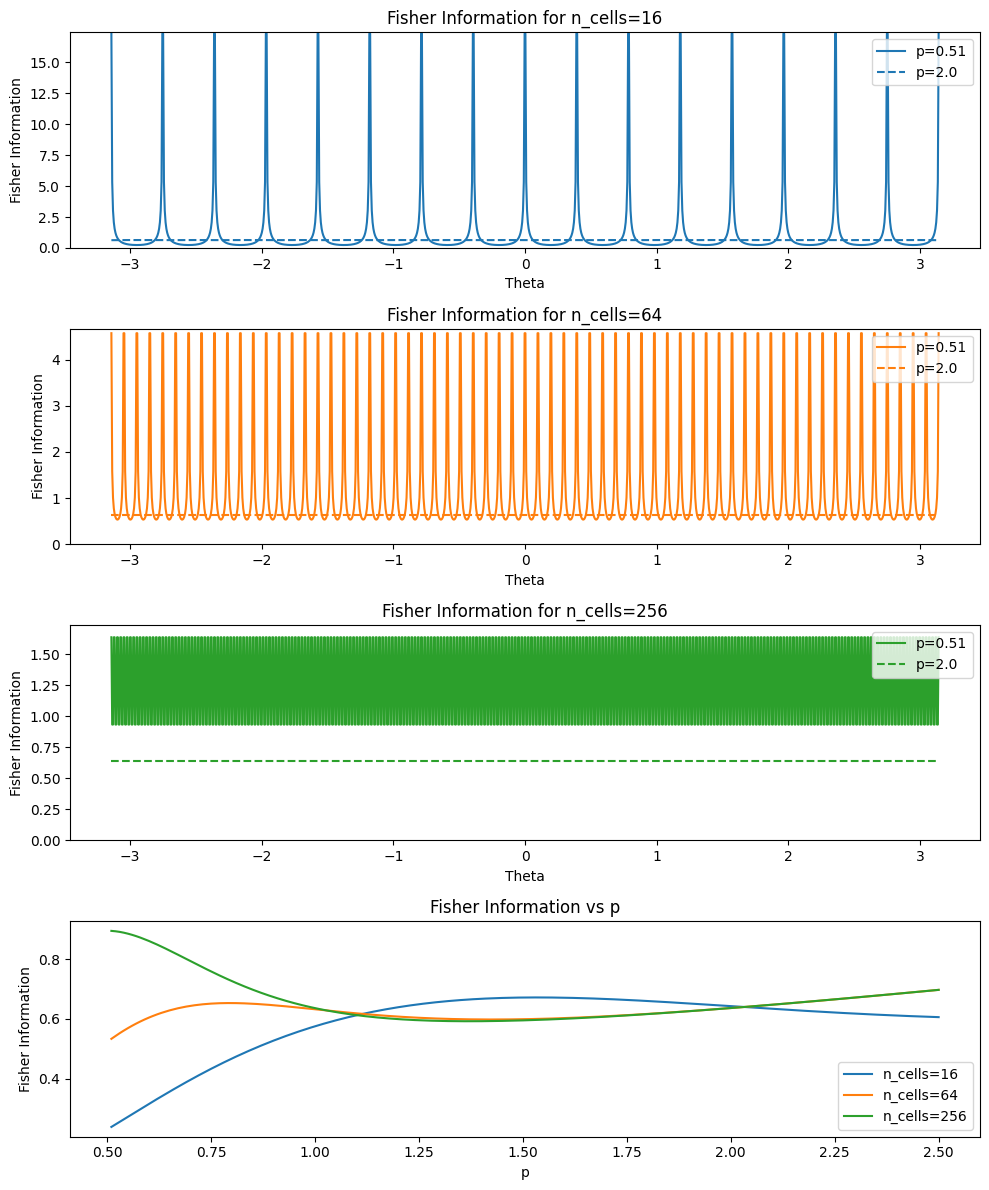

In [ ]:
def g_sq(theta, sigma, p):
    # squared g
    return np.exp(-2 * np.abs(theta/sigma)**p)

def gprime_sq(theta, sigma, p):
    # squared derivative of g
    return (p**2 / sigma**(2*p)
            * np.abs(theta)**(2*(p-1))
            * np.exp(-2 * np.abs(theta/sigma)**p))

# parameters
sigma = 0.5
n_cells = [16 ,64, 256]  # number of cells for different preferences
theta_prefs = [np.linspace(-np.pi, np.pi, n, endpoint=False) + np.pi / n for n in n_cells]
p_vals = np.linspace(0.51, 2.51, 200, endpoint=False)  # p values from 0.51 to 2.51
fisher_info = np.zeros((len(n_cells), len(p_vals)))

# integrate from -pi to pi
for i in range(len(n_cells)):
    for j in range(len(p_vals)):
        p = p_vals[j]
        # compute the sum of (g_i(theta)')^2 for i in range(n_cells)
        fisher_info[i, j] = np.sum([gprime_sq(theta, sigma, p) for theta in theta_prefs[i]]) / n_cells[i]
        norm_factor = quad(lambda t: g_sq(t, sigma, p), -np.pi, np.pi, epsabs=1e-8)[0]
        fisher_info[i, j] /= norm_factor

# plot FI as a function of theta
theta_samples = np.linspace(-np.pi, np.pi, 1024)
fisher_funcs = np.zeros((2, len(n_cells), len(theta_samples)))
for i in range(len(n_cells)):
    template1 = gprime_sq(theta=theta_samples, sigma=sigma, p=p_vals[0])
    norm1 = quad(lambda t: g_sq(t, sigma, p_vals[0]), -np.pi, np.pi, epsabs=1e-8)[0]
    template1 /= norm1  # normalize the template
    template2 = gprime_sq(theta=theta_samples, sigma=sigma, p=2.0)
    norm2 = quad(lambda t: g_sq(t, sigma, 2.0), -np.pi, np.pi, epsabs=1e-8)[0]
    template2 /= norm2  # normalize the template
    # for different j we just need to circularly shift the template by different amounts
    for j in range(n_cells[i]):
        # split the theta_samples into n_cells[i] segments
        segment_length = len(theta_samples) // n_cells[i]
        shifted_template = np.roll(template1, j * segment_length)
        fisher_funcs[0, i, :] += shifted_template / n_cells[i]
        shifted_template = np.roll(template2, j * segment_length)
        fisher_funcs[1, i, :] += shifted_template / n_cells[i]

# plot the FI
cmap = plt.get_cmap('tab10')
plt.figure(figsize=(10, 12))
for i, theta_pref in enumerate(theta_prefs):
    plt.subplot(4, 1, i + 1)
    plt.plot(theta_samples, fisher_funcs[0, i, :], label=f'p={p_vals[0]:.2f}', color=cmap(i))
    # also plot fisher information for p=2
    plt.plot(theta_samples, fisher_funcs[1, i, :], label=f'p=2.0', linestyle='--', color=cmap(i))
    plt.xlabel('Theta')
    plt.ylabel('Fisher Information')
    plt.title(f'Fisher Information for n_cells={n_cells[i]}')
    plt.ylim(0, fisher_funcs[0, i, :].max() + 0.1)
    plt.legend(loc='upper right')

plt.subplot(4, 1, 4)
for i, theta_pref in enumerate(theta_prefs):
    plt.plot(p_vals, fisher_info[i, :], label=f'n_cells={n_cells[i]}', color=cmap(i))
plt.xlabel('p')
plt.ylabel('Fisher Information')
plt.title('Fisher Information vs p')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(p_vals, fisher_info, label='FI', linewidth=2)
plt.xlabel('p')
plt.xlim(0.4, 2.1)
# plt.ylim(0, 5)
plt.ylabel('FI', fontsize=14)
plt.title('Fisher Information for different exponents p', fontsize=14)
plt.vlines([0.5], ymin=0, ymax=fisher_info.max(), color='red', linestyle='--', label='p=0.5')
# get the index closest to 2.0
# closest_index = np.argmin(np.abs(p_vals - 2.0))
# plt.vlines([2.0], ymin=0, ymax=fisher_info[closest_index], color='purple', linestyle='--', label='p=2.0')
# plt.hlines([fisher_info[closest_index]], xmin=0.4, xmax=2.1, color='purple', linestyle='--')
# closest_index = np.argmin(np.abs(p_vals - 1.0))
# plt.vlines([1.0], ymin=0, ymax=fisher_info[closest_index], color='orange', linestyle='--', label='p=1.0')
# plt.hlines([fisher_info[closest_index]], xmin=0.4, xmax=1.0, color='orange', linestyle='--')
# plt.xticks(np.arange(0.4, 2.5, 0.2), fontsize=12)
# plt.grid()
plt.legend(loc='upper right', fontsize=12)
plt.show()

In [ ]:
def h(theta, theta_pref, p=2):
    theta = np.asarray(theta).reshape(-1)  # ensure theta is a 1D array
    theta_pref = np.asarray(theta_pref).reshape(-1)  # ensure theta_pref is a 1D array
    return np.exp(-(utils.circular_distance_rad_np(theta[None, :], theta_pref[:, None])/2) ** p)

# get the squared area under the curve for the function h
energy = lambda theta, p: h(theta, 0, p) ** 2

def g(theta, theta_pref, p=2):
    """
    Compute the response of a neuron given the angle theta and preferred angles theta_pref.
    The response is computed as the squared area under the curve of the function h.
    """
    theta = np.asarray(theta).reshape(-1)  # ensure theta is a 1D array
    theta_pref = np.asarray(theta_pref).reshape(-1)  # ensure theta_pref is a 1D array
    energy_integral, _ = quad(energy, 0, 2 * np.pi, args=(p,))
    return h(theta, theta_pref, p=p) ** 2 / energy_integral

# generate synthetic data
n_theta_samples = 720
n_trials = 8
neural_noise_eps = 0.1  # standard deviation of the noise
# input_noise_eps = 0.1
p = 0.7
n_cells = 32
window_rad = np.pi / 8
theta_pref = np.linspace(2 * np.pi / (2 * n_cells), 2 * np.pi - 2 * np.pi / (2 * n_cells), n_cells)
angle = np.random.uniform(0, 2 * np.pi)
responses = g(angle, theta_pref, p)
responses = np.tile(responses, (1, n_trials)) + neural_noise_eps * np.random.randn(n_cells, n_trials)

# compute posterior distribution
def posterior(theta, responses, p=2):
    """
    Compute the posterior distribution of theta given the responses.
    """
    return np.exp(-np.sum((responses - g(theta, theta_pref, p))**2) / (2 * neural_noise_eps**2))

# choose a random angle and compute the posterior distribution given the responses
theta_samples = np.linspace(0, 2 * np.pi, n_theta_samples, endpoint=False)
posterior_samples = np.array([posterior(theta, responses, p) for theta in theta_samples])
posterior_samples /= np.sum(posterior_samples)  # normalize the posterior distribution

# plot the posterior distribution
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
cmap = plt.get_cmap('tab10')
for i in range(n_cells):
    jittered_angle = angle + np.random.uniform(-0.01, 0.01, size=n_trials)
    plt.plot(theta_samples, g(theta_samples, theta_pref[i], p)[0], color=cmap(i % 6))
    plt.scatter(jittered_angle, responses[i], c=cmap(i % 6), marker='x', s=50)
plt.vlines(angle, ymin=0, ymax=1, color='k', linestyles='--',label='True Angle')
plt.title('Synthetic Data (p=0.7)')
plt.xlabel('Theta')
plt.ylabel('Response')
plt.ylim(0, g(theta_samples, theta_pref, p).max() + 0.1)
plt.xlim(angle - window_rad, angle + window_rad)
plt.legend(loc='upper right', fontsize=12)

plt.subplot(2, 2, 3)
plt.plot(theta_samples, posterior_samples, label='Likelihood', color='k', linewidth=2)
plt.vlines(angle, ymin=0, ymax=0.5, color='red', label='True Angle', linestyle='--', linewidth=2)
# plot the argmax of the posterior distribution
argmax_theta = theta_samples[np.argmax(posterior_samples)]
plt.vlines(argmax_theta, ymin=0, ymax=0.5, color='blue', label='MLE', linestyle=':', linewidth=2)
# plot difference between true angle and argmax
plt.text(argmax_theta + 0.025, 0.1, f'Diff: {np.abs(argmax_theta - angle):.2f}', color='blue', fontsize=12)
plt.title('Likelihood (p=0.7)', fontsize=12)
plt.xlabel('Theta')
plt.ylabel('likelihood')
plt.legend(loc='upper right', fontsize=12)
plt.xlim(angle - window_rad, angle + window_rad)

# compute for p = 2
responses = g(angle, theta_pref, p=2)
responses = np.tile(responses, (1, n_trials)) + neural_noise_eps * np.random.randn(n_cells, n_trials)
theta_samples = np.linspace(0, 2 * np.pi, n_theta_samples, endpoint=False)
posterior_samples = np.array([posterior(theta, responses, p=2) for theta in theta_samples])
posterior_samples /= np.sum(posterior_samples)  # normalize the posterior distribution
plt.subplot(2, 2, 2)
for i in range(n_cells):
    # add jitter to angle for better visibility
    jittered_angle = angle + np.random.uniform(-0.01, 0.01, size=n_trials)
    plt.plot(theta_samples, g(theta_samples, theta_pref[i], p=2)[0], color=cmap(i % 6))
    plt.scatter(jittered_angle, responses[i], c=cmap(i % 6), marker='x')
plt.vlines(angle, ymin=0, ymax=1, color='k', linestyles='--',label='True Angle')
plt.title('Synthetic Data (p=2)', fontsize=12)
plt.xlabel('Theta')
plt.ylabel('Response')
plt.ylim(0, g(theta_samples, theta_pref, p=2).max() + 0.1)
plt.legend(loc='upper right', fontsize=12)
plt.xlim(angle - window_rad, angle + window_rad)

plt.subplot(2, 2, 4)
plt.plot(theta_samples, posterior_samples, label='Likelihood', color='k', linewidth=2)
plt.vlines(angle, ymin=0, ymax=0.5, color='red', label='True Angle', linestyle='--', linewidth=2)
# plot the argmax of the posterior distribution
argmax_theta = theta_samples[np.argmax(posterior_samples)]
plt.vlines(argmax_theta, ymin=0, ymax=0.5, color='blue', label='MLE', linestyle=':', linewidth=2)
# plot difference between true angle and argmax
plt.text(argmax_theta + 0.025, 0.1, f'Diff: {np.abs(argmax_theta - angle):.2f}', color='blue', fontsize=12)
plt.title('Likelihood (p=2)', fontsize=12)
plt.xlabel('Theta')
plt.ylabel('likelihood')
plt.legend(loc='upper right', fontsize=12)
plt.xlim(angle - window_rad, angle + window_rad)

plt.tight_layout()
plt.show()